In [ ]:
import QuantLib as ql
from scipy.optimize import minimize
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

# Preprocessing

In [73]:
price_data = pd.read_csv('data/cleaned_price_data.csv')

price_data["pd_QuoteDate"] = pd.to_datetime(price_data["Quote Date"])

daily_df = {}

for date, group in price_data.groupby("Quote Date"):
    daily_df[date] = group[['S','K','T','C','r']].reset_index(drop=True)

days = list(daily_df.keys())
pd_days = [pd.to_datetime(d).normalize() for d in days]

daily_df['2023-10-02'].head()

,S,K,T,C,r
0,427.36,330.0,0.068493,98.635,0.051833
1,427.36,335.0,0.068493,93.700,0.051833
2,427.36,340.0,0.068493,88.720,0.051833
3,427.36,345.0,0.068493,83.535,0.051833
4,427.36,350.0,0.068493,78.815,0.051833


## Calibration

In [78]:
def build_static_ql_objects(spot, rf, q):
    today = ql.Date().todaysDate()
    ql.Settings.instance().evaluationDate = today
    
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot))
    rf_curve = ql.YieldTermStructureHandle(
        ql.FlatForward(today, rf, ql.Actual365Fixed()))
    div_curve = ql.YieldTermStructureHandle(
        ql.FlatForward(today, q, ql.Actual365Fixed()))

    return today, spot_handle, rf_curve, div_curve

def build_option_list(strikes, maturities, today, engine):
    option_list = []
    for K, T in zip(strikes, maturities):
        
        payoff = ql.PlainVanillaPayoff(ql.Option.Call, K)
        exercise = ql.EuropeanExercise(today + int(T * 365))
        option = ql.VanillaOption(payoff, exercise)
        
        option.setPricingEngine(engine)

        option_list.append(option)
    return option_list

In [ ]:
#Optimized Heston Pricer - use the same model, just rewrite params
def calibration_objective(params, prices, option_list, model):
    ql_params = ql.Array(params.tolist())
    model.setParams(ql_params)

    sq_errors =  [(opt.NPV() - p)**2 for opt, p in zip(option_list, prices)]
    return np.sum(sq_errors)

#Main Calibration Function
def calibrate_heston(dataset, spot, rf, q):
    today, spot_handle, rf_curve, div_curve = build_static_ql_objects(spot, rf, q)

    prices = dataset['C'].values
    strikes = dataset['K'].values
    maturities = dataset['T'].values

    initial_guess = np.array([0.05, 1.0, 0.3, -0.6, 0.02])
    theta, kappa, sigma, rho, v0 = initial_guess

    bounds = [
        (0.01, 0.10),   # theta
        (1.5, 20.0),    # kappa
        (0.5, 10.0),    # sigma
        (-0.8, -0.5),   # rho
        (0.001, 0.05)   # v0
    ]

    heston_process = ql.HestonProcess(
        rf_curve, div_curve, spot_handle,
        v0, kappa, theta, sigma, rho
    )

    model = ql.HestonModel(heston_process)
    engine = ql.AnalyticHestonEngine(model, 32)
    option_list = build_option_list(strikes, maturities, today, engine)

    result = minimize(
        calibration_objective,
        initial_guess,
        args=(prices, option_list, model),
        bounds=bounds,
        method="L-BFGS-B")

    return result.x, result.fun

In [152]:
day = '2023-10-02'
S = daily_df[day].loc[0,'S']

start = time.time()
calibrated_params, err = calibrate_heston(daily_df[day], S, 0.05, 0.012)
stop = time.time()

params = pd.Series(calibrated_params, index=['theta','kappa','sigma','rho','v0'])

print(f"Calibration completed in {stop-start:.2f} seconds\n")

print("Calibrated Parameters:")
print(params.to_string(index=True))

print("\nCalibration Error:", err)

Calibration completed in 6.17 seconds

Calibrated Parameters:
theta    0.062088
kappa    2.142413
sigma    1.031802
rho     -0.749369
v0       0.031304

Calibration Error: 216.50918365571948


In [156]:
from joblib import Parallel, delayed

def calibrate_one_day(day_data):
    spot = day_data.loc[0,'S']
    rf = day_data.loc[0,'r']
    q = 0.012
    params, _ = calibrate_heston(day_data, spot, rf, q)
    return params

results = Parallel(n_jobs=-1)(
    delayed(calibrate_one_day)(daily_df[day])
    for day in days
)

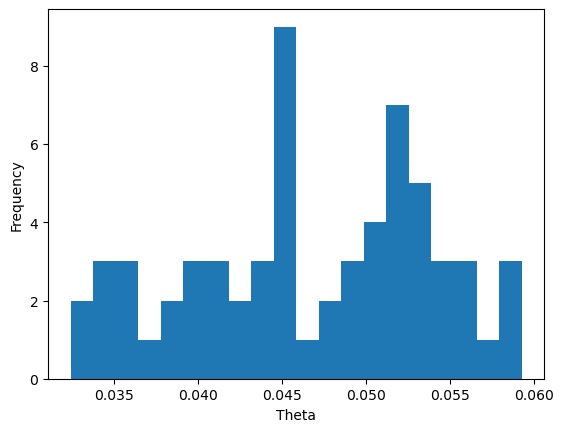

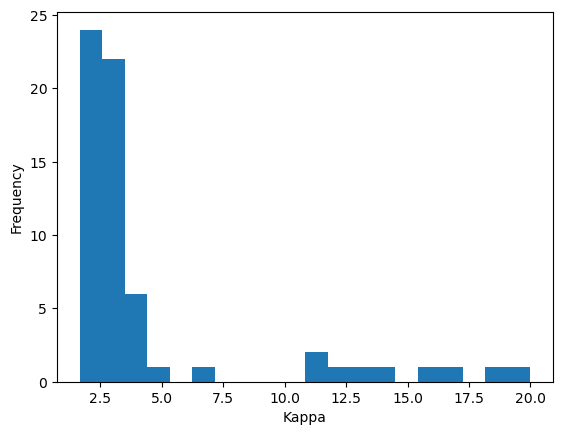

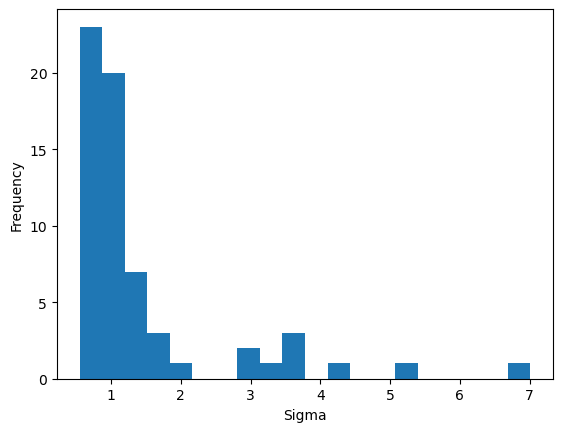

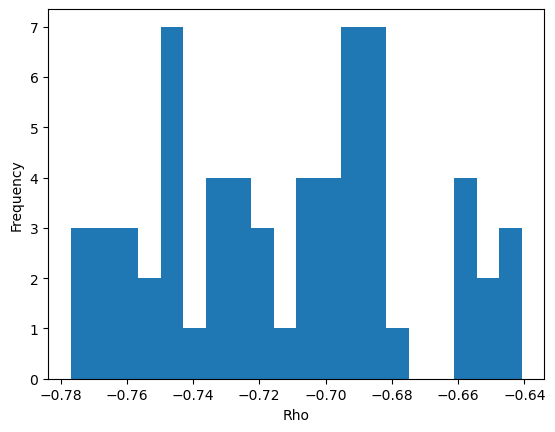

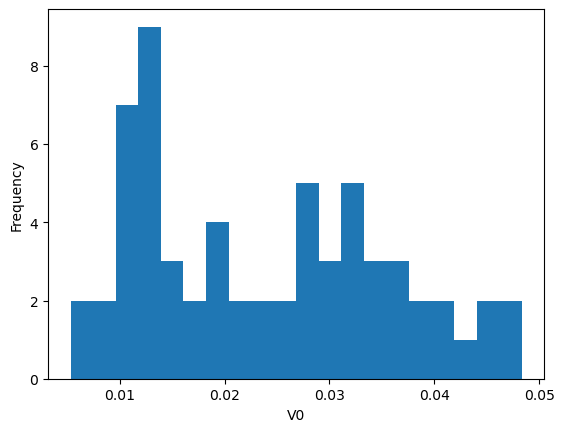

In [157]:
res = pd.DataFrame(np.array(results))
res.columns = ['theta','kappa','sigma','rho','v0']

for col in res.columns:
    plt.hist(res[col],bins=20)

    plt.xlabel(col.capitalize())
    plt.ylabel('Frequency')
    plt.show()